In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from time import time
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from imblearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

# Download necessary NLTK packages
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume_lemm.csv")
df.head()

,ID,Resume_str,Category
0,16852973,hr administrator marketing associate hr admini...,HR
1,22323967,hr specialist u hr operation summary versatile...,HR
2,33176873,hr director summary over year experience in re...,HR
3,27018550,hr specialist summary dedicated driven and dyn...,HR
4,17812897,hr manager skill highlight hr skill hr departm...,HR


In [5]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Resume_str'])

In [ ]:
def preprocess(text):
    tokens = word_tokenize(text)
    return tokens

resume_token = df['Resume_str'].apply(preprocess)

0    [hr, administrator, marketing, associate, hr, ...
1    [hr, specialist, u, hr, operation, summary, ve...
2    [hr, director, summary, over, year, experience...
3    [hr, specialist, summary, dedicated, driven, a...
4    [hr, manager, skill, highlight, hr, skill, hr,...
Name: Resume_str, dtype: object


In [ ]:
w2v_model = Word2Vec(
    sentences=resume_token,       # The tokenized resumes used as training data
    vector_size=200,              # Dimensionality of the word vectors
    window=10,                    # Number of context words to consider to the left and right of the target word
    min_count=2,                  # Ignores all words with total frequency lower than this
    epochs=40                     # Number of iterations (epochs)
)


In [ ]:
print(f"Number of words in the Word2Vec vocabulary: {len(w2v_model.wv.index_to_key)}")

Numero di parole nel vocabolario Word2Vec: 19968


In [ ]:
def advanced_pooling_weighted(vectors, weights):
    weights = np.array(weights)
    weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)

    weighted_mean = np.average(vectors, axis=0, weights=weights)
    max_ = np.max(vectors, axis=0)
    min_ = np.min(vectors, axis=0)
    var_ = np.var(vectors, axis=0)
    std_ = np.std(vectors, axis=0)
    median = np.median(vectors, axis=0)
    q25 = np.percentile(vectors, 25, axis=0)
    q75 = np.percentile(vectors, 75, axis=0)

    return np.concatenate([weighted_mean, max_, min_, var_, std_, median, q25, q75])

def get_advanced_weighted_vector(tokens, model, tfidf_vectorizer, tfidf_row, vector_size=50):
    word2idx = tfidf_vectorizer.vocabulary_
    vectors = []
    weights = []

    for word in tokens:
        if word in model.wv and word in word2idx:
            vectors.append(model.wv[word])
            weights.append(tfidf_row[0, word2idx[word]])

    if len(vectors) == 0:
        return np.zeros(8 * vector_size)  # 8 statistiche usate

    return advanced_pooling_weighted(np.array(vectors), weights)

In [ ]:
# 7. Applica la trasformazione a tutti i documenti
df['vector'] = [
    get_advanced_weighted_vector(row['tokens'], w2v_model, tfidf_vectorizer, tfidf_matrix[i], vector_size=50)
    for i, row in df.iterrows()
]

In [8]:
X = np.vstack(df['vector'].values)
y = df['Category']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986, 1600)
Validation data size: (497, 1600)


## Random Forest Classifier

In [11]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
class_counts = y_train.value_counts()
min_classes = class_counts[class_counts < 0.8*class_counts.mean()].index.tolist()

print(f"Applicazione di SMOTE alle classi: {min_classes}")

target_size = int(0.7*class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applicazione di SMOTE alle classi: ['ADVOCATE', 'APPAREL', 'BPO', 'AGRICULTURE', 'ARTS', 'AUTOMOBILE']


In [14]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=3)),      # k_neighbors utile per le classi con pochi samples
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [15]:
# 2. Definisci i parametri per il grid search
param_grid = {
    'clf__n_estimators': [400, 700],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [5],
    'clf__criterion' : ['gini', 'entropy'],
    'clf__min_samples_split': [10],
    'clf__min_samples_leaf': [15]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(X_train, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_) 

GridSearchCV took 230.08 seconds for 8 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.480 (std: 0.015)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}

Model with rank: 2
Mean validation score: 0.478 (std: 0.016)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}

Model with rank: 3
Mean validation score: 0.463 (std: 0.016)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}

Model with rank: 4
Mean validation score: 0.463 (std: 0.020)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 

In [16]:
print(grid_search.best_params_)

{'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}


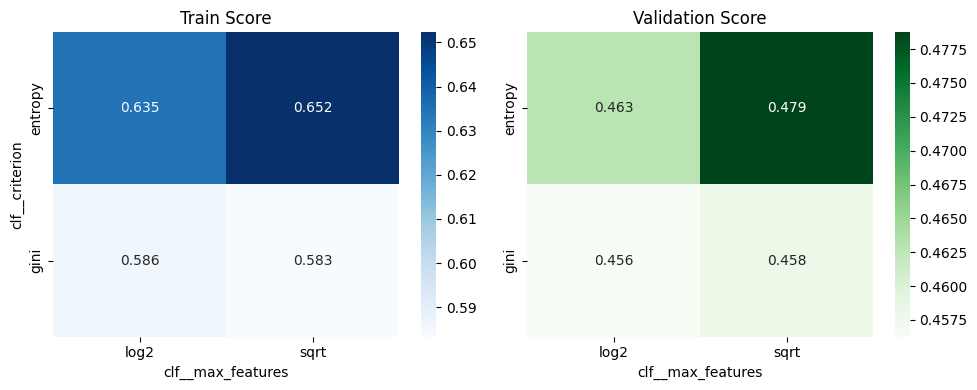

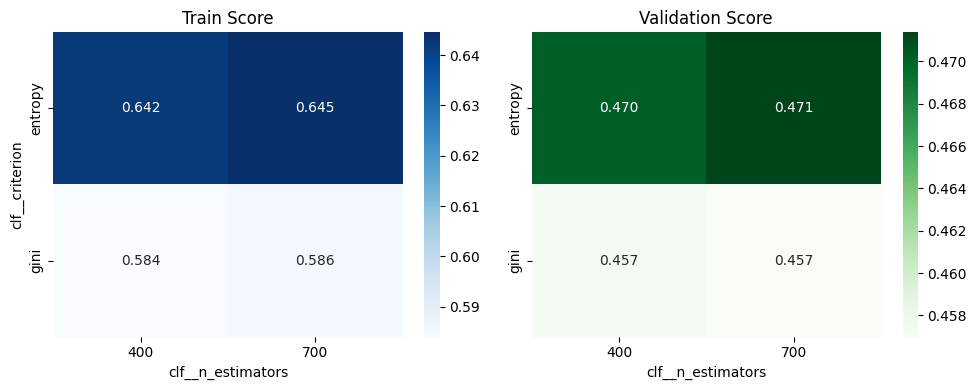

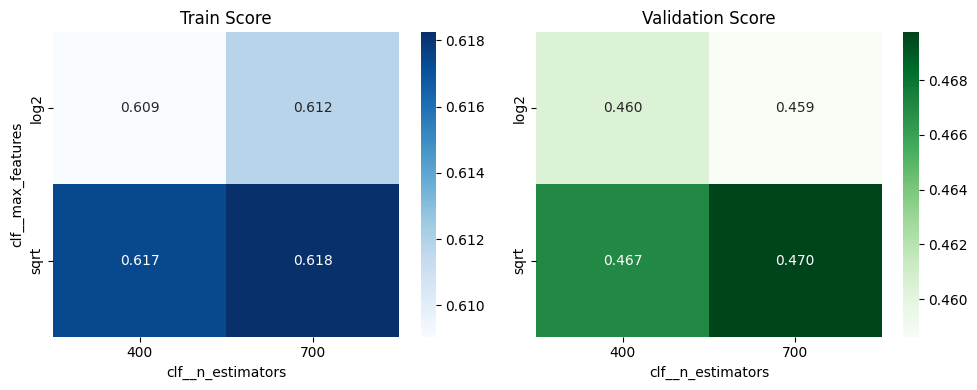

In [17]:
# DataFrame con i risultati
results = pd.DataFrame(grid_search.cv_results_)
param_cols = [col for col in results.columns if col.startswith("param_")]

# Converti tutti i parametri in stringa per la pivot table
for p in param_cols:
    results[p] = results[p].astype(str)

# Heatmap per ogni coppia di parametri
for p1, p2 in combinations(param_cols, 2):
    try:
        pivot_val = results.pivot_table(values='mean_test_score', index=p1, columns=p2)
        pivot_train = results.pivot_table(values='mean_train_score', index=p1, columns=p2)

        if pivot_val.shape[0] > 1 and pivot_val.shape[1] > 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            sns.heatmap(pivot_train, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
            axes[0].set_title(f"Train Score")
            axes[0].set_xlabel(p2.replace("param_", ""))
            axes[0].set_ylabel(p1.replace("param_", ""))

            sns.heatmap(pivot_val, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
            axes[1].set_title(f"Validation Score")
            axes[1].set_xlabel(p2.replace("param_", ""))
            axes[1].set_ylabel("")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Errore con {p1} e {p2}: {e}")

In [18]:
RF_Model_best = grid_search.best_estimator_
prediction = RF_Model_best.predict(X_test)

In [19]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train, y_train)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test, y_test)))

Training Score: 0.68
Test Score: 0.55


In [20]:
print(classification_report(y_test, prediction))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.73      0.89      0.80        27
              ADVOCATE       0.75      0.46      0.57        13
           AGRICULTURE       0.17      0.33      0.22         6
               APPAREL       0.67      0.55      0.60        11
                  ARTS       0.07      0.25      0.11         4
            AUTOMOBILE       0.00      0.00      0.00         2
              AVIATION       1.00      0.21      0.35        19
               BANKING       1.00      0.06      0.11        18
                   BPO       0.27      0.30      0.29        10
  BUSINESS-DEVELOPMENT       0.40      0.62      0.48        34
                  CHEF       0.82      0.90      0.86        20
          CONSTRUCTION       0.93      0.64      0.76        22
            CONSULTANT       0.00      0.00      0.00        25
              DESIGNER       0.77      0.45      0.57        22
         DIGITAL-MEDIA       1.00      

c:\Users\andre\anaconda3\envs\ResumeProject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\envs\ResumeProject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\envs\ResumeProject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

<Figure size 1500x1000 with 0 Axes>

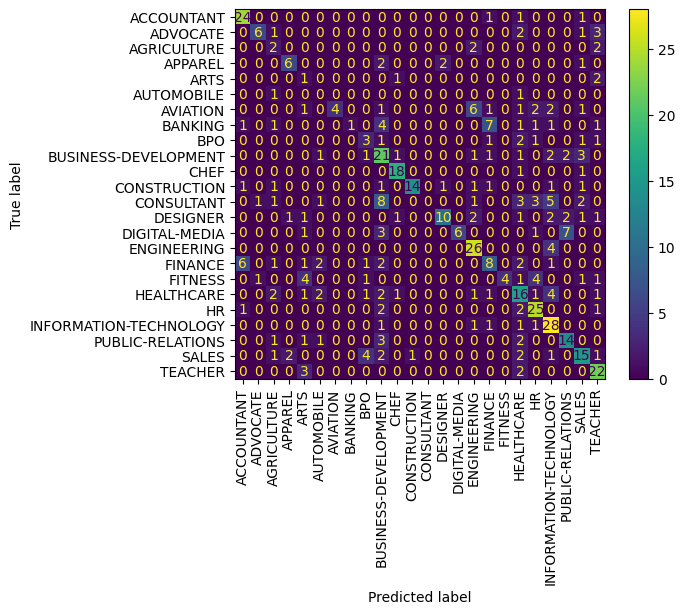

In [21]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

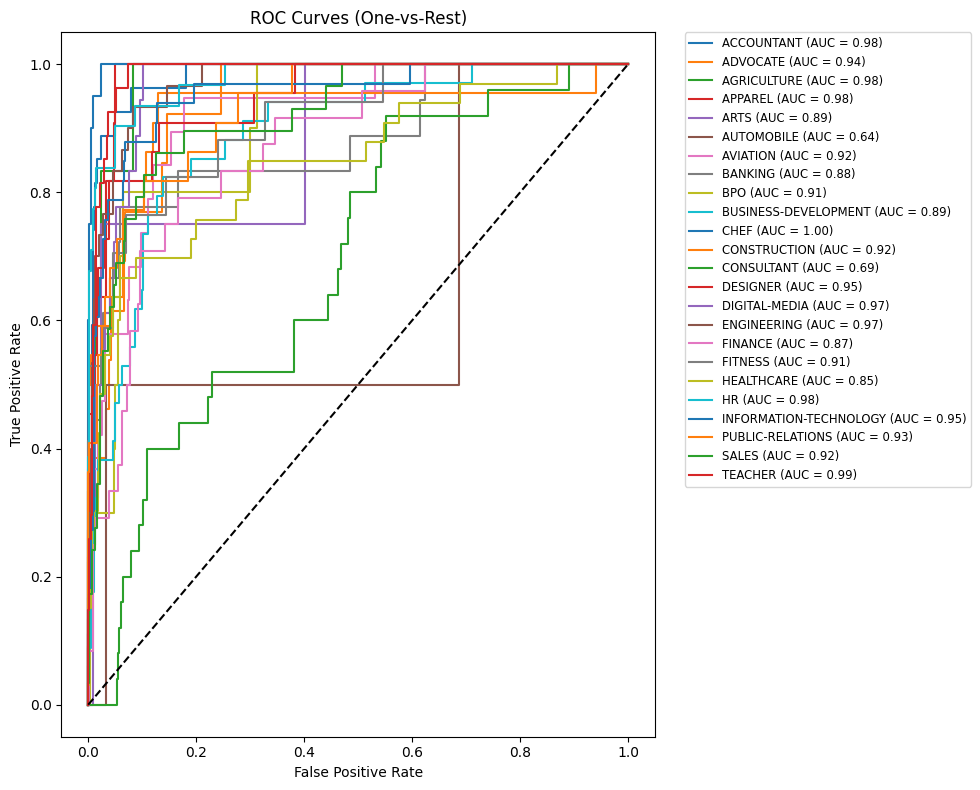

In [22]:
y_test_bin = label_binarize(y_test, classes=RF_Model_best.classes_)
y_score = RF_Model_best.predict_proba(X_test)

plt.figure(figsize=(10, 8))

for i in range(len(RF_Model_best.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{RF_Model_best.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")

# Sposta la legenda fuori dal grafico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

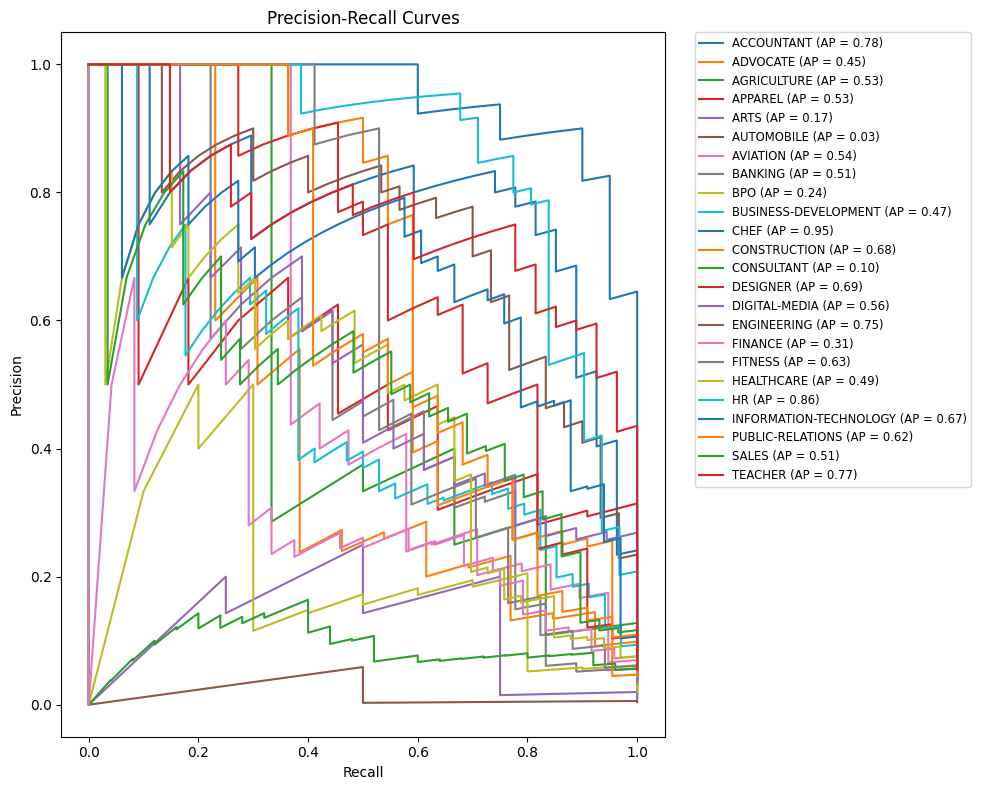

In [23]:
plt.figure(figsize=(10, 8))

for i in range(len(RF_Model_best.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{RF_Model_best.classes_[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")

# Legenda esterna a destra
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

In [24]:
import sys
sys.path.append('..')

from utils import save_experiment_W2V

save_experiment_W2V(w2v_model, grid_search, RF_Model_best, X_train, y_train, X_test, y_test)

✅ Riga di log aggiunta in 'experiment_log.txt':
RandomForestClassifier(clf__criterion=entropy, clf__max_depth=5, clf__max_features=sqrt, clf__min_samples_leaf=15, clf__min_samples_split=10, clf__n_estimators=700) | W2V(vector_size=200, window=10, min_count=2, epochs=40) | Accuracy train=0.680, test=0.551

